In [1]:
import selenium
from selenium import webdriver
from selenium.webdriver.common.by import By
from selenium.webdriver.support.ui import WebDriverWait
from selenium.webdriver.support import expected_conditions as EC
import pandas as pd

import requests
from bs4 import BeautifulSoup

In [23]:
driver = webdriver.Chrome()
url = 'https://www.imdb.com/search/title/?sort=user_rating,desc&groups=top_100'
driver.get(url)

In [24]:
#Set initial empty list for each element:
title = []
link = []
year = []
duration = []
rating = []
#-------Grab the block of each individual movie------
block = driver.find_elements(By.CLASS_NAME, "ipc-metadata-list-summary-item")

for i in range(len(block)):
    
    ftitle = block[i].find_element(By.CLASS_NAME, "ipc-title__text").text[3:]

    fyear = block[i].find_element(By.CLASS_NAME, "dli-title-metadata").text
    
    fyear, fduration, frating = fyear.split("\n")[0], fyear.split("\n")[1], fyear.split("\n")[2]

    flink = block[i].find_element(By.CLASS_NAME, "ipc-title-link-wrapper").get_attribute('href')

    title.append(ftitle)
    year.append(fyear)
    duration.append(fduration)
    rating.append(frating)
    link.append(flink)

print(len(link))

50


In [26]:
#--------Set an empty list to store user review link--------
user_review_links = []
i = 0
for url in link:
    #setup user agent for BS4, except some rare case, it would be the same for most browser 
    user_agent = {'User-agent': 'Mozilla/5.0'}
    #Use request.get to load the whole page
    response = requests.get(url, headers = user_agent)
    #Parse the requests object to BS4 to transform it into html structure
    soup = BeautifulSoup(response.text, 'html.parser')
    #Find the link marked by the USER REVIEWS link text.
    review_link = 'https://www.imdb.com'+soup.find('a', string = 'User reviews').get('href')
    #Append the newly grabed link into its list
    print(i, review_link)
    i += 1
    user_review_links.append(review_link)
    

0 https://www.imdb.com/title/tt0111161/reviews/?ref_=tt_ql_2
1 https://www.imdb.com/title/tt0068646/reviews/?ref_=tt_ql_2
2 https://www.imdb.com/title/tt0468569/reviews/?ref_=tt_ql_2
3 https://www.imdb.com/title/tt0167260/reviews/?ref_=tt_ql_2
4 https://www.imdb.com/title/tt0108052/reviews/?ref_=tt_ql_2
5 https://www.imdb.com/title/tt0050083/reviews/?ref_=tt_ql_2
6 https://www.imdb.com/title/tt0071562/reviews/?ref_=tt_ql_2
7 https://www.imdb.com/title/tt0110912/reviews/?ref_=tt_ql_2
8 https://www.imdb.com/title/tt0120737/reviews/?ref_=tt_ql_2
9 https://www.imdb.com/title/tt0137523/reviews/?ref_=tt_ql_2
10 https://www.imdb.com/title/tt1375666/reviews/?ref_=tt_ql_2
11 https://www.imdb.com/title/tt0109830/reviews/?ref_=tt_ql_2
12 https://www.imdb.com/title/tt0167261/reviews/?ref_=tt_ql_2
13 https://www.imdb.com/title/tt0060196/reviews/?ref_=tt_ql_2
14 https://www.imdb.com/title/tt0816692/reviews/?ref_=tt_ql_2
15 https://www.imdb.com/title/tt0099685/reviews/?ref_=tt_ql_2
16 https://www.imd

In [17]:
top_50_data = {'Movie_name': title, 
        'Year': year, 
        'link': link,
        'user_review' : user_review_links,
}
top50 = pd.DataFrame(data = top_50_data)

top50.head()

,Movie_name,Year,link,user_review
0,The Shawshank Redemption,1994,https://www.imdb.com/title/tt0111161/?ref_=sr_t_1,https://www.imdb.com/title/tt0111161/reviews/?...
1,The Godfather,1972,https://www.imdb.com/title/tt0068646/?ref_=sr_t_2,https://www.imdb.com/title/tt0068646/reviews/?...
2,The Dark Knight,2008,https://www.imdb.com/title/tt0468569/?ref_=sr_t_3,https://www.imdb.com/title/tt0468569/reviews/?...
3,The Lord of the Rings: The Return of the King,2003,https://www.imdb.com/title/tt0167260/?ref_=sr_t_4,https://www.imdb.com/title/tt0167260/reviews/?...
4,Schindler's List,1993,https://www.imdb.com/title/tt0108052/?ref_=sr_t_5,https://www.imdb.com/title/tt0108052/reviews/?...


In [3]:
driver.quit()

In [20]:
#--------Scrape 1000 reviews for each movie--------
for i in range(len(top50['user_review'])): 
    driver = webdriver.Chrome()
    driver.get(top50['user_review'][i])
    driver.implicitly_wait(1) # tell the webdriver to wait for 1 seconds for the page to load to prevent blocked by anti spam software

    for page in range(2):  
        try:
            #find the load more button on the webpage
            WebDriverWait(driver, 20).until(EC.element_to_be_clickable((By.XPATH, "//*[@id=\"load-more-trigger\"]"))).click()

        except:
            #If couldn't find any more button to click, stop
            break
        
    # After fully expand the page, we will grab data from whole website
    review = driver.find_elements(By.CLASS_NAME, 'review-container')
    title = []
    content = []
    rating = []
    date = []
    user_name = []
    
    for n in range(len(review)):
        try:
            #Check if each review has all the elements
            ftitle = review[n].find_element(By.CLASS_NAME,'title').text
            #For the review content, some of them are hidden as spoiler, 
            #so we use the attribute 'textContent' here after extracting the 'content' tag
            fcontent = review[n].find_element(By.CLASS_NAME,'content').get_attribute("textContent").strip()

            if fcontent.split("\n")[-1].strip() == "Permalink":
                fcontent = " ".join(fcontent.split("\n")[:-3])
            
            frating = review[n].find_element(By.CLASS_NAME,'rating-other-user-rating').text
            fdate = review[n].find_element(By.CLASS_NAME,'review-date').text
            fname = review[n].find_element(By.CLASS_NAME,'display-name-link').text

            #Then add them to the respective list
            title.append(ftitle)
            content.append(fcontent)
            rating.append(frating)
            date.append(fdate)
            user_name.append(fname)
        except:
            continue
        
    #Build data dictionary for dataframe
    data = {'User_name': user_name, 
            'Review title': title, 
            'Review Rating': rating,
            'Review date' : date,
            'Review_body' : content
    }
    #Build dataframe for each movie to export
    review = pd.DataFrame(data = data)
    movie = top50['Movie_name'][i] #grab the movie name from the top50 list    
    review['Movie_name'] = movie #create new column with the same movie name column    
    review.to_csv(f'data/{i+1}.csv') #store them into individual file for each movies, so we can combine or check them later
    driver.quit()

In [28]:
df_raw = pd.read_csv('data/1.csv') #Create a base dataframe from the first movie review file
for i in range(1, 51):
    add = pd.read_csv(f'data/{i}.csv')
    df_raw = pd.concat([df_raw,add], ignore_index=True) #Concat the rest into main dataframe
    
df_raw.to_csv(f'data/final.csv')

In [37]:
df_raw.columns

Index(['Unnamed: 0', 'User_name', 'Review title', 'Review Rating',
       'Review date', 'Review_body', 'Movie_name'],
      dtype='object')

In [40]:
df_raw = df_raw.drop('Unnamed: 0', axis='columns')
df_raw.tail(10)

,User_name,Review title,Review Rating,Review date,Review_body,Movie_name
2277,murtaza_mma,A Potpourri of Vestiges Review: A piquant cock...,10/10,4 March 2010,Once Upon a Time in the West (OUTW) is a piqua...,Once Upon a Time in the West
2278,ccthemovieman-1,Excruciating Slow Or Fascinating: Your Choice,7/10,28 June 2006,"This was a unique western, one in which someti...",Once Upon a Time in the West
2279,Red-Barracuda,A beautiful western,10/10,30 December 2010,Once Upon A Time In The West is no ordinary we...,Once Upon a Time in the West
2280,disinterested_spectator,Reverse Quotations,10/10,20 January 2015,I was in college when this movie came out. I h...,Once Upon a Time in the West
2281,Leofwine_draca,"In a word, masterful",9/10,22 September 2016,"A lyrical, thoughtful spaghetti western from S...",Once Upon a Time in the West
2282,Steffi_P,"""Something to do with death""",10/10,19 March 2007,It's funny how so many of the greatest western...,Once Upon a Time in the West
2283,Hey_Sweden,Cinematic brilliance from Sergio Leone.,10/10,17 February 2014,"""Once Upon a Time in the West"" is a truly epic...",Once Upon a Time in the West
2284,Freddy_Levit,Once Upon A Time.......................There w...,10/10,28 November 2004,No other films in the world have produced such...,Once Upon a Time in the West
2285,paul2001sw-1,There's a train a'coming...,5/10,8 January 2009,Most westerns are actually about the death of ...,Once Upon a Time in the West
2286,mjneu59,the end of the Old West,9/10,22 December 2010,If Sam Peckinpah's Wild Bunch killed off the W...,Once Upon a Time in the West


In [9]:
import selenium
from selenium import webdriver
from selenium.webdriver.common.by import By
from selenium.webdriver.support.ui import WebDriverWait
from selenium.webdriver.support import expected_conditions as EC
import pandas as pd

import requests
from bs4 import BeautifulSoup

def get_reviews(url, folder_name):
    driver = webdriver.Chrome()
    driver.get(url)
    
        #Set initial empty list for each element:
    title = []
    link = []
    year = []
    duration = []
    rating = []
    #-------Grab the block of each individual movie------
    block = driver.find_elements(By.CLASS_NAME, "ipc-metadata-list-summary-item")

    for i in range(len(block)):
        
        ftitle = block[i].find_element(By.CLASS_NAME, "ipc-title__text").text[3:]
        fyear = block[i].find_element(By.CLASS_NAME, "dli-title-metadata").text
        try:
            fyear, fduration, frating = fyear.split("\n")[0], fyear.split("\n")[1], fyear.split("\n")[2]
        except:
            fyear, fduration, frating = fyear.split("\n")[0], fyear.split("\n")[1], 'Not Rated'
        flink = block[i].find_element(By.CLASS_NAME, "ipc-title-link-wrapper").get_attribute('href')

        title.append(ftitle)
        year.append(fyear)
        duration.append(fduration)
        rating.append(frating)
        link.append(flink)
    
    #--------Set an empty list to store user review link--------
    user_review_links = []
    i = 0
    for review_url in link:
        #setup user agent for BS4, except some rare case, it would be the same for most browser 
        user_agent = {'User-agent': 'Mozilla/5.0'}
        #Use request.get to load the whole page
        response = requests.get(review_url, headers = user_agent)
        #Parse the requests object to BS4 to transform it into html structure
        soup = BeautifulSoup(response.text, 'html.parser')
        #Find the link marked by the USER REVIEWS link text.
        review_link = 'https://www.imdb.com'+soup.find('a', string = 'User reviews').get('href')
        #Append the newly grabed link into its list
        i += 1
        user_review_links.append(review_link)
        
    top_50_data = {'Movie_name': title, 
        'Year': year, 
        'link': link,
        'user_review' : user_review_links,
    }
    top50 = pd.DataFrame(data = top_50_data)
    driver.quit()
    
        #--------Scrape 1000 reviews for each movie--------
    for i in range(len(top50['user_review'])): 
        driver = webdriver.Chrome()
        driver.get(top50['user_review'][i])
        driver.implicitly_wait(1) # tell the webdriver to wait for 1 seconds for the page to load to prevent blocked by anti spam software

        for page in range(2):  
            try:
                #find the load more button on the webpage
                WebDriverWait(driver, 20).until(EC.element_to_be_clickable((By.XPATH, "//*[@id=\"load-more-trigger\"]"))).click()

            except:
                #If couldn't find any more button to click, stop
                break
            
        # After fully expand the page, we will grab data from whole website
        review = driver.find_elements(By.CLASS_NAME, 'review-container')
        title = []
        content = []
        rating = []
        date = []
        user_name = []
        
        for n in range(len(review)):
            try:
                #Check if each review has all the elements
                ftitle = review[n].find_element(By.CLASS_NAME,'title').text
                #For the review content, some of them are hidden as spoiler, 
                #so we use the attribute 'textContent' here after extracting the 'content' tag
                fcontent = review[n].find_element(By.CLASS_NAME,'content').get_attribute("textContent").strip()

                if fcontent.split("\n")[-1].strip() == "Permalink":
                    fcontent = " ".join(fcontent.split("\n")[:-3])
                
                frating = review[n].find_element(By.CLASS_NAME,'rating-other-user-rating').text
                fdate = review[n].find_element(By.CLASS_NAME,'review-date').text
                fname = review[n].find_element(By.CLASS_NAME,'display-name-link').text

                #Then add them to the respective list
                title.append(ftitle)
                content.append(fcontent)
                rating.append(frating)
                date.append(fdate)
                user_name.append(fname)
            except:
                continue
            
        #Build data dictionary for dataframe
        data = {'User_name': user_name, 
                'Review title': title, 
                'Review Rating': rating,
                'Review date' : date,
                'Review_body' : content
        }
        #Build dataframe for each movie to export
        review = pd.DataFrame(data = data)
        movie = top50['Movie_name'][i] #grab the movie name from the top50 list    
        review['Movie_name'] = movie #create new column with the same movie name column    
        review.to_csv(f'{folder_name}/{i+1}.csv') #store them into individual file for each movies, so we can combine or check them later
        driver.quit()
        
    df_raw = pd.read_csv(f'{folder_name}/1.csv') #Create a base dataframe from the first movie review file
    for i in range(1, 51):
        add = pd.read_csv(f'{folder_name}/{i}.csv')
        df_raw = pd.concat([df_raw,add], ignore_index=True) #Concat the rest into main dataframe
        
    df_raw.to_csv(f'{folder_name}/final.csv')

In [5]:
top100_link = 'https://www.imdb.com/search/title/?sort=user_rating,desc&groups=top_100'
get_reviews(top100_link, 'top50_raw')

In [10]:
bottom100_link = 'https://www.imdb.com/search/title/?sort=user_rating,asc&groups=bottom_100'
get_reviews(bottom100_link, 'bottom50_raw')

In [21]:
#pip3 install nltk
#pip3 install gensim
#pip3 install spacy

import nltk
from nltk import FreqDist
import pandas as pd
pd.set_option("display.max_colwidth", 200)
import numpy as np
import spacy
import gensim
from gensim import corpora
import matplotlib.pyplot as plt
import seaborn as sns
import json
import re
import gzip
import pyLDAvis
import pyLDAvis.gensim

In [33]:
def freq_words(x, terms = 30):
  all_words = ' '.join([text for text in x])
  all_words = all_words.split()
  
  fdist = FreqDist(all_words)
  words_df = pd.DataFrame({'word':list(fdist.keys()), 'count':list(fdist.values())})
  
  # selecting top 20 most frequent words
  d = words_df.nlargest(columns="count", n = terms) 
  plt.figure(figsize=(20,5))
  ax = sns.barplot(data=d, x= "word", y = "count", hue="word")
  ax.set(ylabel = 'Count')
  plt.show()

In [4]:
top50 = pd.read_csv('top50_raw/final.csv')
bottom50 = pd.read_csv('bottom50_raw/final.csv')

top50.columns

Index(['Unnamed: 0.1', 'Unnamed: 0', 'User_name', 'Review title',
       'Review Rating', 'Review date', 'Review_body', 'Movie_name'],
      dtype='object')

In [5]:
top50 = top50.drop('Unnamed: 0.1', axis='columns')
top50 = top50.drop('Unnamed: 0', axis='columns')
bottom50 = bottom50.drop('Unnamed: 0.1', axis='columns')
bottom50 = bottom50.drop('Unnamed: 0', axis='columns')
top50.columns

Index(['User_name', 'Review title', 'Review Rating', 'Review date',
       'Review_body', 'Movie_name'],
      dtype='object')

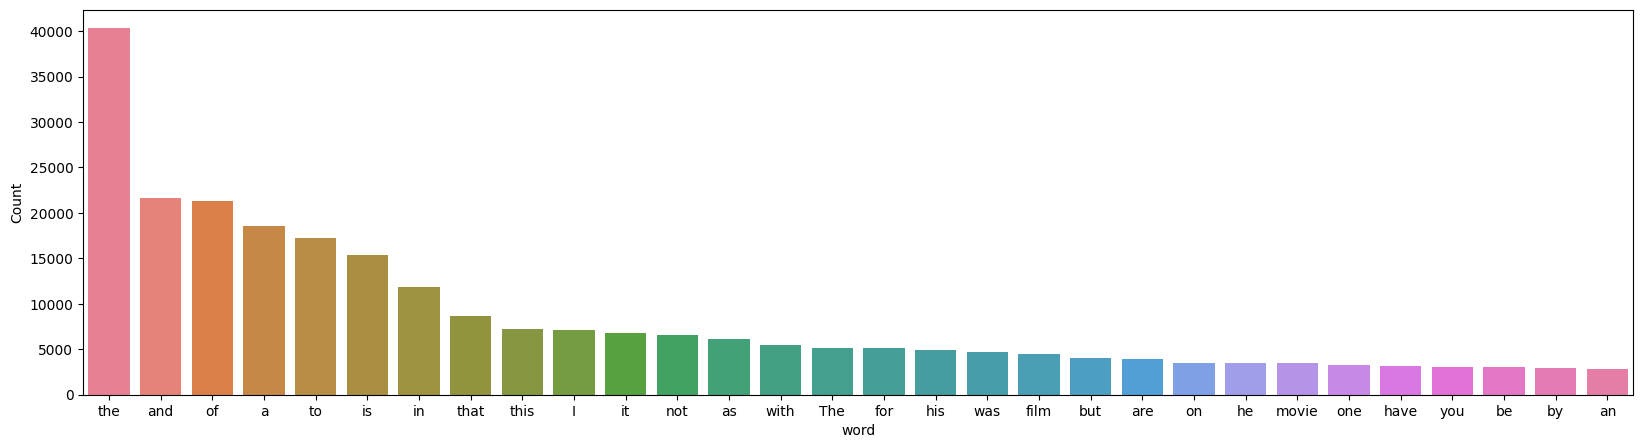

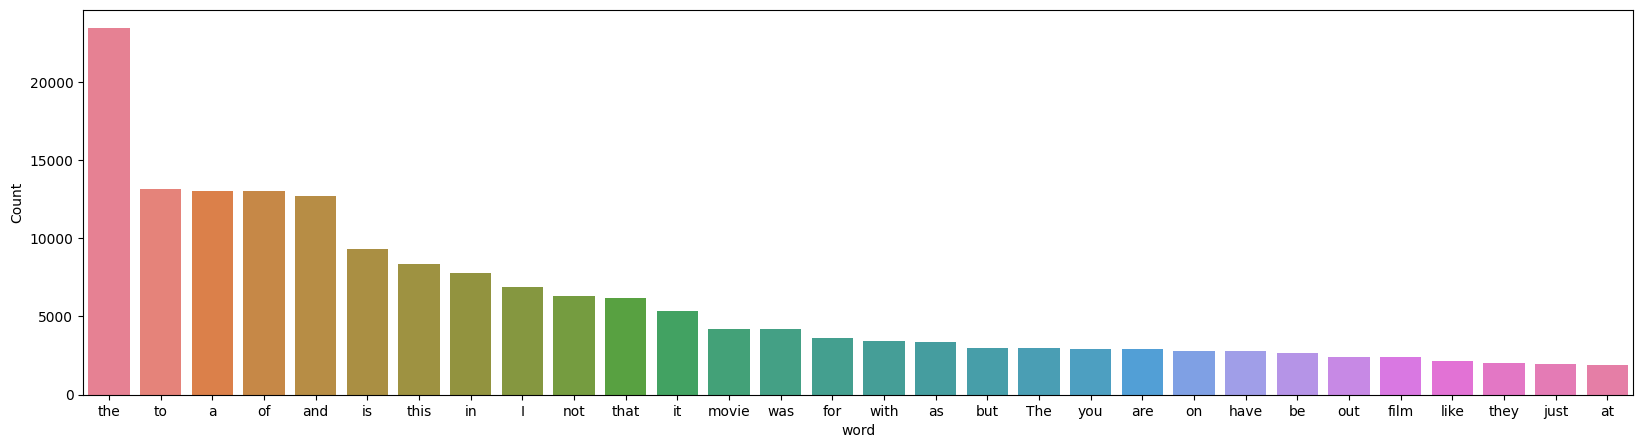

In [32]:
freq_words(top50['Review_body'])
freq_words(bottom50['Review_body'])

In [27]:
top50['Review_body'] = top50['Review_body'].str.replace("n\'t", " not")
top50['Review_body'] = top50['Review_body'].str.replace("[^a-zA-Z#]", " ")

bottom50['Review_body'] = bottom50['Review_body'].str.replace("n\'t", " not")
bottom50['Review_body'] = bottom50['Review_body'].str.replace("[^a-zA-Z#]", " ")

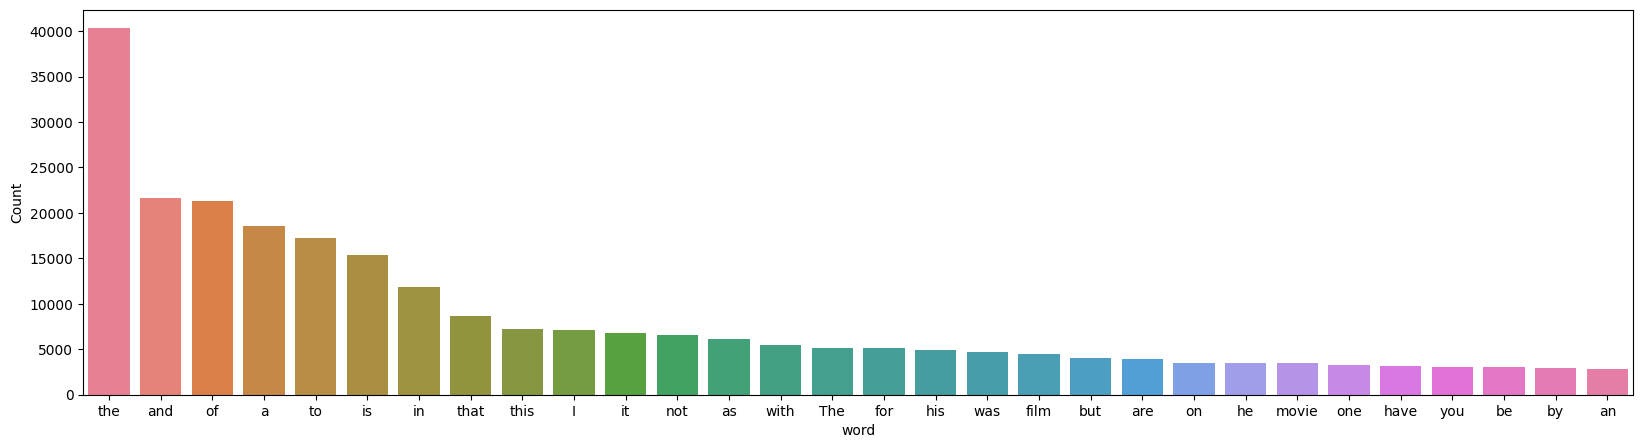

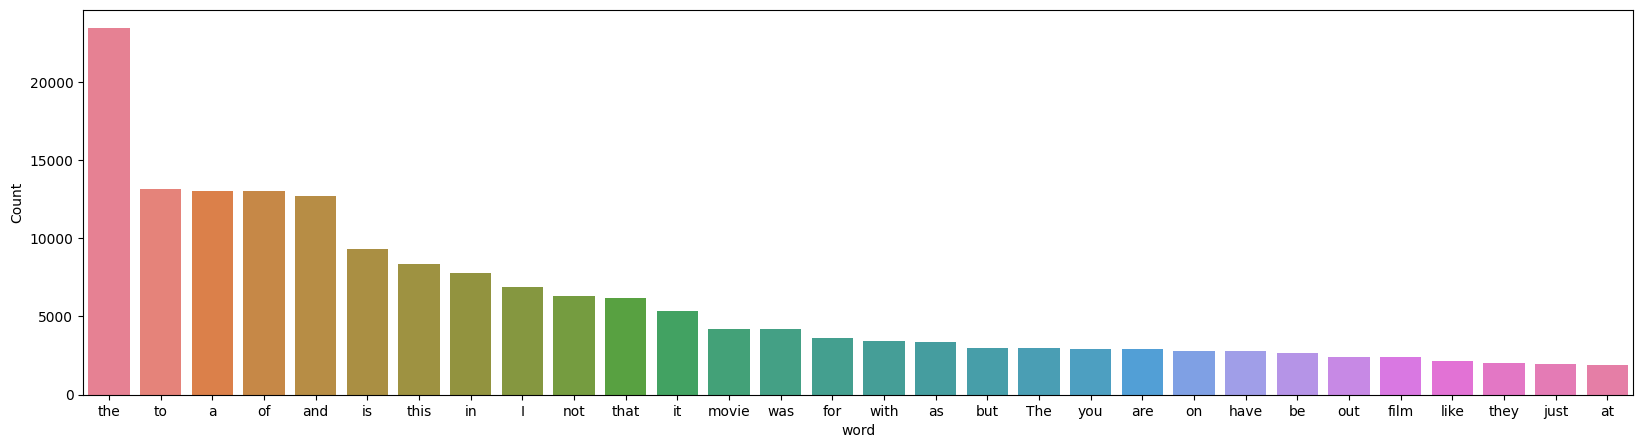

In [34]:
freq_words(top50['Review_body'])
freq_words(bottom50['Review_body'])

In [35]:
nltk.download('stopwords')
from nltk.corpus import stopwords
stop_words = stopwords.words('english')

[nltk_data] Error loading stopwords: <urlopen error [SSL:
[nltk_data]     CERTIFICATE_VERIFY_FAILED] certificate verify failed:
[nltk_data]     unable to get local issuer certificate (_ssl.c:992)>


In [36]:

# function to remove stopwords
def remove_stopwords(rev):
  rev_new = " ".join([i for i in rev if i not in stop_words])
  return rev_new
     

In [37]:
# remove short words (length < 3)
top50['Review_body'] = top50['Review_body'].apply(lambda x: ' '.join([w for w in x.split() if len(w)>2]))

# remove stopwords from the text
reviews_top = [remove_stopwords(r.split()) for r in top50['Review_body']]

# make entire text lowercase
reviews_top = [r.lower() for r in reviews_top]

In [38]:
# remove short words (length < 3)
bottom50['Review_body'] = bottom50['Review_body'].apply(lambda x: ' '.join([w for w in x.split() if len(w)>2]))

# remove stopwords from the text
reviews_bot = [remove_stopwords(r.split()) for r in bottom50['Review_body']]

# make entire text lowercase
reviews_bot = [r.lower() for r in reviews_bot]

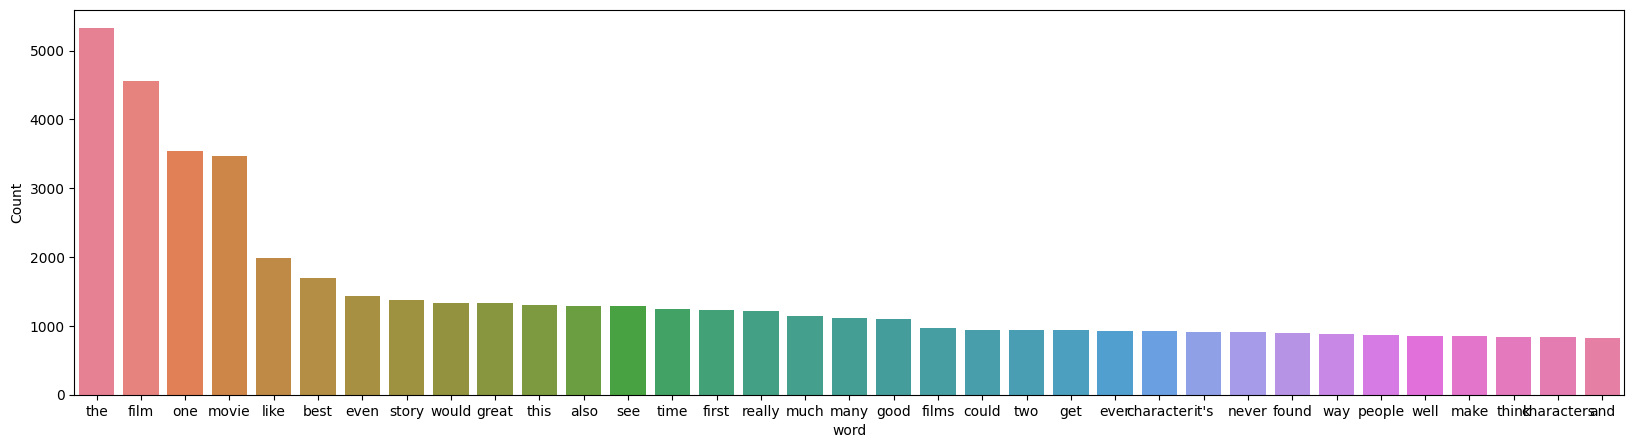

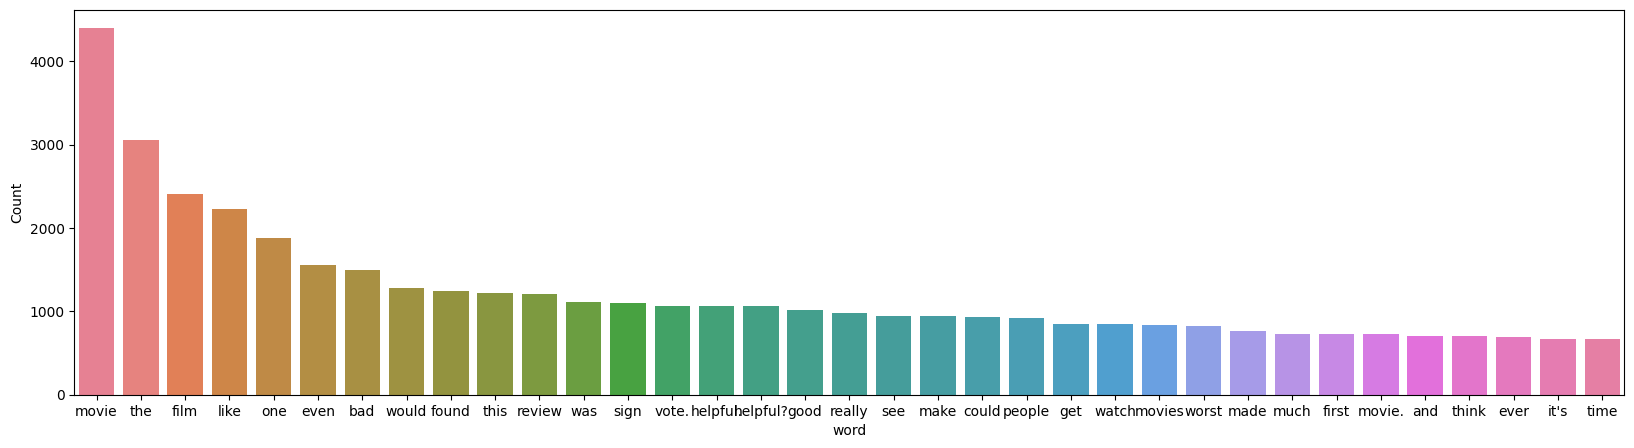

In [39]:
freq_words(reviews_top, 35)
freq_words(reviews_bot, 35)

In [40]:
# remove unwanted characters, numbers and symbols
reviews_top = [re.sub("[^a-zA-Z#]", " ", i) for i in reviews_top]
reviews_bot = [re.sub("[^a-zA-Z#]", " ", i) for i in reviews_bot]

In [41]:
# remove short words (length < 3)
reviews_top = [' '.join([w for w in sent.split() if len(w)>2]) for sent in reviews_top]
reviews_bot = [' '.join([w for w in sent.split() if len(w)>2]) for sent in reviews_bot]

In [42]:
reviews_top = [remove_stopwords(sent.split()) for sent in reviews_top]
reviews_bot = [' '.join([w for w in sent.split() if len(w)>2]) for sent in reviews_bot]

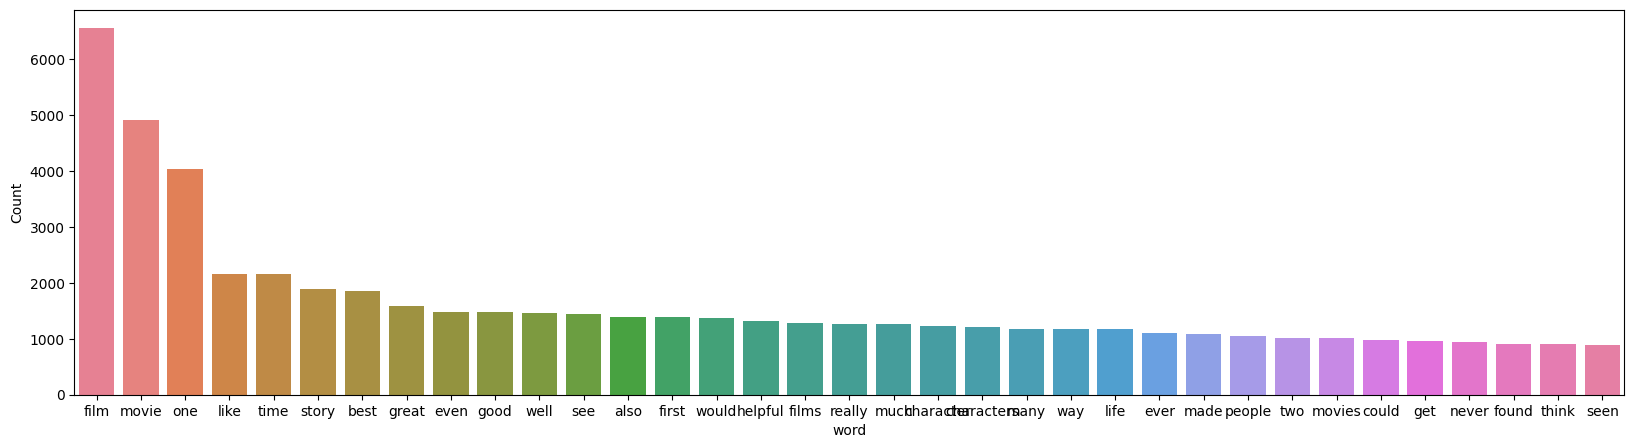

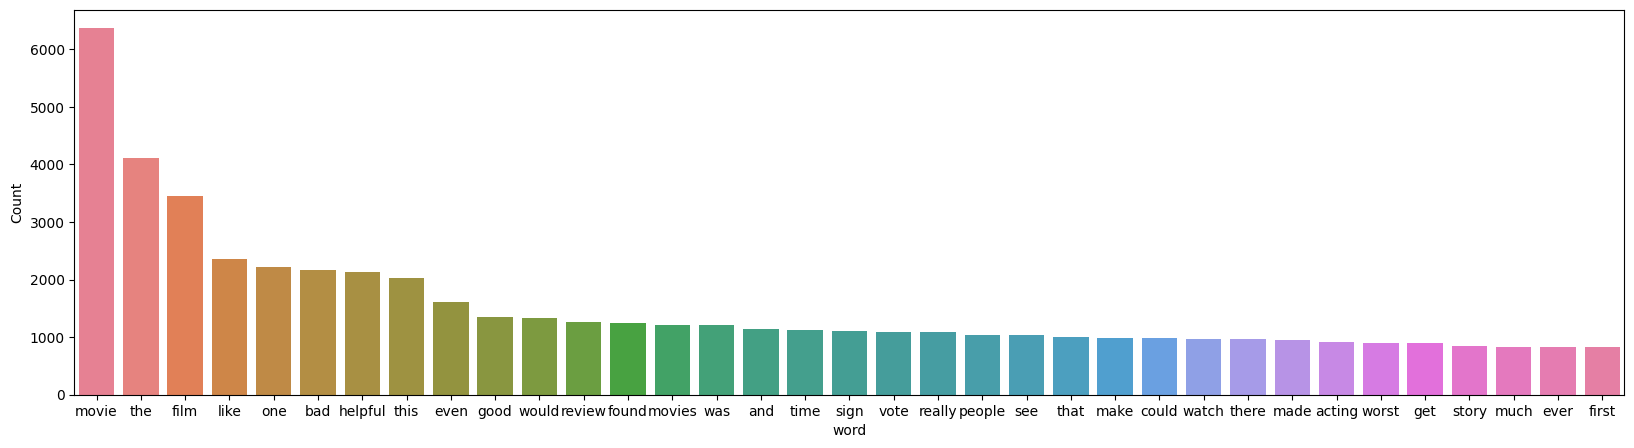

In [43]:
freq_words(reviews_top, 35)
freq_words(reviews_bot, 35)

In [54]:
!python3 -m spacy download en

⚠ As of spaCy v3.0, shortcuts like 'en' are deprecated. Please use the
full pipeline package name 'en_core_web_sm' instead.
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 12.8/12.8 MB 15.3 MB/s eta 0:00:0000:0100:01

[notice] A new release of pip is available: 23.0.1 -> 23.3.2
[notice] To update, run: pip3 install --upgrade pip
✔ Download and installation successful
You can now load the package via spacy.load('en_core_web_sm')


In [58]:
nlp = spacy.load('en_core_web_sm', disable=['parser', 'ner'])

In [59]:
def lemmatization(texts, tags=['NOUN', 'ADJ']):
    output = []
    for sent in texts:
        doc = nlp(" ".join(sent)) 
        output.append([token.lemma_ for token in doc if token.pos_ in tags])
    return output

In [63]:
tokenized_topreviews = pd.Series(reviews_top).apply(lambda x: x.split())
print(tokenized_topreviews[1])

['wonder', 'film', 'high', 'rating', 'quite', 'literally', 'breathtaking', 'say', 'said', 'much', 'story', 'acting', 'premise', 'movie', 'makes', 'feel', 'sometimes', 'watch', 'film', 'remember', 'days', 'later', 'film', 'loves', 'seen', 'forget', 'ultimate', 'story', 'friendship', 'hope', 'life', 'overcoming', 'adversity', 'understand', 'many', 'class', 'best', 'film', 'time', 'mine', 'get', 'seen', 'seen', 'time', 'need', 'watch', 'amazing', 'found', 'helpful', 'review', 'helpful', 'sign', 'vote']


In [64]:
tokenized_botreviews = pd.Series(reviews_bot).apply(lambda x: x.split())
print(tokenized_botreviews[1])

['week', 'ago', 'watched', 'daniel', 'der', 'zauberer', 'wanted', 'give', 'chance', 'bad', 'reviews', 'received', 'this', 'foolish', 'idea', 'ended', 'waste', 'precious', 'time', 'the', 'plot', 'reads', 'follows', 'boy', 'became', 'famous', 'show', 'problems', 'people', 'like', 'music', 'the', 'main', 'character', 'played', 'daniel', 'kueblboeck', 'new', 'star', 'germans', 'pop', 'idol', 'kueblboeck', 'actually', 'plays', 'himself', 'after', 'proud', 'made', 'movie', 'honest', 'watched', 'till', 'end', 'write', 'the', 'movie', 'bad', 'almost', 'hurts', 'physically', 'warning', 'not', 'watch', 'this', 'movie', 'not', 'give', 'chance', 'unless', 'either', 'masochist', 'blb', 'fan', 'say', 'want', 'you', 'this', 'movie', 'receive', 'voting', 'instead', 'awful', 'found', 'helpful', 'was', 'review', 'helpful', 'sign', 'vote']


In [66]:
reviews_top = lemmatization(tokenized_topreviews)
print(reviews_top[1])

['wonder', 'film', 'high', 'rating', 'breathtaking', 'much', 'story', 'acting', 'premise', 'movie', 'feel', 'film', 'day', 'film', 'ultimate', 'story', 'friendship', 'hope', 'life', 'adversity', 'many', 'class', 'good', 'film', 'time', 'time', 'need', 'amazing', 'helpful', 'review', 'helpful', 'sign', 'vote']


In [67]:
reviews_bot = lemmatization(tokenized_botreviews)
print(reviews_bot[1])

['week', 'chance', 'bad', 'review', 'foolish', 'idea', 'waste', 'precious', 'time', 'plot', 'read', 'boy', 'famous', 'show', 'problem', 'people', 'music', 'main', 'character', 'new', 'idol', 'proud', 'movie', 'end', 'movie', 'bad', 'movie', 'chance', 'movie', 'voting', 'awful', 'helpful', 'helpful', 'sign', 'vote']


In [76]:

# Create the term dictionary of our corpus, where every unique term is assigned an index
dictionary = corpora.Dictionary(reviews_top)

In [70]:
doc_term_matrix = [dictionary_top.doc2bow(rev) for rev in reviews_top]

In [71]:

# Creating the object for LDA model using gensim library
LDA = gensim.models.ldamodel.LdaModel

In [72]:

# Build LDA model
lda_model = LDA(corpus=doc_term_matrix,
                id2word=dictionary,
                num_topics=7, 
                random_state=100,
                chunksize=1000,
                passes=50)

In [73]:
lda_model.print_topics()

[(0,
  '0.025*"ring" + 0.017*"battle" + 0.015*"book" + 0.014*"forr" + 0.013*"trilogy" + 0.013*"fellowship" + 0.012*"tower" + 0.010*"gump" + 0.009*"dream" + 0.009*"frodo"'),
 (1,
  '0.026*"film" + 0.012*"character" + 0.012*"movie" + 0.012*"time" + 0.012*"scene" + 0.009*"man" + 0.009*"good" + 0.007*"performance" + 0.007*"western" + 0.007*"story"'),
 (2,
  '0.055*"movie" + 0.045*"film" + 0.020*"good" + 0.016*"story" + 0.015*"great" + 0.015*"time" + 0.013*"character" + 0.009*"life" + 0.009*"many" + 0.009*"people"'),
 (3,
  '0.109*"helpful" + 0.060*"review" + 0.058*"vote" + 0.057*"sign" + 0.032*"movie" + 0.030*"film" + 0.021*"good" + 0.015*"great" + 0.010*"story" + 0.007*"amazing"'),
 (4,
  '0.036*"prison" + 0.013*"mile" + 0.012*"mcmurphy" + 0.012*"redemption" + 0.011*"green" + 0.010*"mental" + 0.010*"patient" + 0.009*"nurse" + 0.009*"nest" + 0.009*"cuckoo"'),
 (5,
  '0.016*"pianist" + 0.015*"film" + 0.012*"german" + 0.012*"nazi" + 0.012*"war" + 0.010*"schindler" + 0.010*"polanski" + 0.010*

In [74]:
# Visualize the topics
pyLDAvis.enable_notebook()
vis = pyLDAvis.gensim.prepare(lda_model, doc_term_matrix, dictionary)
vis

PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
6     -0.114314 -0.018588       1        1  35.800559
2     -0.194670  0.009085       2        1  28.884229
1     -0.137899 -0.018757       3        1  19.609734
3     -0.026169  0.246788       4        1   5.055498
5     -0.015451 -0.215177       5        1   4.351025
0      0.214794 -0.018802       6        1   4.244808
4      0.273709  0.015452       7        1   2.054147, topic_info=        Term         Freq        Total Category  logprob  loglift
134  helpful  1180.000000  1180.000000  Default  30.0000  30.0000
69     movie  5271.000000  5271.000000  Default  29.0000  29.0000
140   review   803.000000   803.000000  Default  28.0000  28.0000
143     vote   624.000000   624.000000  Default  27.0000  27.0000
141     sign   613.000000   613.000000  Default  26.0000  26.0000
..       ...          ...          ...      ...      ...      ...
41    fellow    14.199640    44.091541   Topic7  -5.7371   2.7523
62       job    19.288007   315.246679   Topic7  -5.4308   1.0914
107    state    14.881461    78.681522   Topic7  -5.6902   2.2200
32      easy    15.063026   106.392542   Topic7  -5.6780   1.9304
188    oscar    15.299462   251.935918   Topic7  -5.6625   1.0840

[448 rows x 6 columns], token_table=      Topic      Freq    Term
term                         
452       1  0.728919  action
452       2  0.140384  action
452       3  0.071542  action
452       4  0.028347  action
452       6  0.029697  action
...     ...       ...     ...
354       2  0.381679    year
354       3  0.118089    year
354       4  0.005272    year
354       5  0.011598    year
354       7  0.007381    year

[757 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[7, 3, 2, 4, 6, 1, 5])

In [77]:

# Create the term dictionary of our corpus, where every unique term is assigned an index
dictionary = corpora.Dictionary(reviews_bot)
doc_term_matrix = [dictionary.doc2bow(rev) for rev in reviews_bot]
LDA = gensim.models.ldamodel.LdaModel

# Build LDA model
lda_model = LDA(corpus=doc_term_matrix,
                id2word=dictionary,
                num_topics=7, 
                random_state=100,
                chunksize=1000,
                passes=50)

# Visualize the topics
pyLDAvis.enable_notebook()
vis = pyLDAvis.gensim.prepare(lda_model, doc_term_matrix, dictionary)
vis

PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
4      0.214810  0.041368       1        1  57.398453
1      0.168569  0.080097       2        1  16.650407
0      0.150633  0.111749       3        1  14.988010
3      0.079813 -0.305419       4        1   5.773270
2     -0.211209  0.052714       5        1   2.849989
5     -0.226604  0.005532       6        1   1.965979
6     -0.176012  0.013961       7        1   0.373891, topic_info=          Term         Freq        Total Category  logprob  loglift
88       movie  7107.000000  7107.000000  Default  30.0000  30.0000
164    helpful  1792.000000  1792.000000  Default  29.0000  29.0000
174       vote   927.000000   927.000000  Default  28.0000  28.0000
173       sign   919.000000   919.000000  Default  27.0000  27.0000
9          bad  3284.000000  3284.000000  Default  26.0000  26.0000
...        ...          ...          ...      ...      ...      ...
11110    belly     0.782893     3.784513   Topic7  -6.5488   4.0133
4664    hilton     0.742533     3.515063   Topic7  -6.6017   4.0342
6886     caddy     0.940396    16.377023   Topic7  -6.3655   2.7316
2281     shelf     0.640641    11.631637   Topic7  -6.7493   2.6899
2335    addict     0.521279     3.860988   Topic7  -6.9555   3.5866

[449 rows x 6 columns], token_table=      Topic      Freq      Term
term                           
803       1  0.976075  absolute
915       1  0.996035   abysmal
386       1  0.592801       act
386       2  0.060800       act
386       3  0.152000       act
...     ...       ...       ...
157       1  0.407604     young
157       2  0.472821     young
157       3  0.119564     young
1212      1  0.478503    zombie
1212      6  0.511503    zombie

[679 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[5, 2, 1, 4, 3, 6, 7])